## Homework 1: ImageGPT

Мы привыкли, что для работы с изображениями нужны сверточные сети. Но что, если взглянуть на задачу под другим углом? В этой работе мы отойдем от классического подхода и исследуем, как можно применить архитектуру **Трансформер** для генерации изображений. Для этого мы реализуем архитектуру **ImageGPT**, которая обрабатывает изображения так же, как классический GPT работает с текстом - как с последовательностью токенов.

### Основная идея
Эта идея впервые подробно была описана в работе [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) от **OpenAI**. Её авторы показали, что если представить изображение в виде последовательности, то модель способна обучиться не хуже, чем классические сверточные сети. 

Суть этой идеи в том, что вместо сверточных слоёв **ImageGPT** преобразует изображение в последовательность квантованных пикселей, которые выступают в роли токенов. Эта последовательность затем подаётся на вход GPT, и модель учится предсказывать следующий токен.

### Задание
Вам предстоит реализовать основные блоки архитектуры ImageGPT и обучить модель на датасете `CIFAR-10` для решения задачи генерации изображений.

За выполнение домашнего задания можно получить до **10 баллов**. Для части заданий мы написали для вас скелет. Заполните в них пропуски, выделенные с помощью `...`

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.cluster import KMeans

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Задание 1: Dataset (0.5 балла)

Для обучения нашей модели мы будем использовать популярный датасет `CIFAR-10`. Он состоит из $60 000$ цветных изображений размером $32\times 32$ пикселя, разделенных на $10$ классов.

Датасет уже за вас поделен на **50 000** обучающих и **10 000** тестовых изображений.

Для удобства дальнейшей работы нам нужно получить датасет в формате Dataset из PyTorch. Проще всего получить из библиотеки `torchvision.datasets`.

In [2]:
from torchvision.datasets import CIFAR10

- Создайте преобразования `transforms` с аугментациями `RandomCrop` и `RandomHorizontalFlip` для обучающего (`train_dataset`) и без аугментации для валидационного (`val_dataset`) датасетов.
- Загрузите CIFAR-10 с соответствующими преобразованиями
- Создайте DataLoaders для каждого датасета

In [3]:
# Преобразования для обучающего датасета
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
    ])

# Преобразования для валидационного датасета
val_transform = transforms.Compose(
    [
        transforms.ToTensor()
    ])

# Загружаем датасеты с соответствующими преобразованиями
train_dataset = CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

val_dataset = CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=val_transform
)

# Параметры загрузки
batch_size = 2
num_workers = 4
to_use_pin_memory = (device.type == 'cuda')

# Создаём генераторы батчей
# для трейна
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=to_use_pin_memory
    # так быстрее, но нельзя уйти в swap (часть данных система тащит на диск, если оперативки не хватает)
)
# для валидации
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=to_use_pin_memory
)

Прежде чем приступить к построению модели всегда полезно взглянуть на данные, с которыми предстоит работать. Это даёт общее представление о данных и позволяет убедиться, что всё загрузилось корректно.

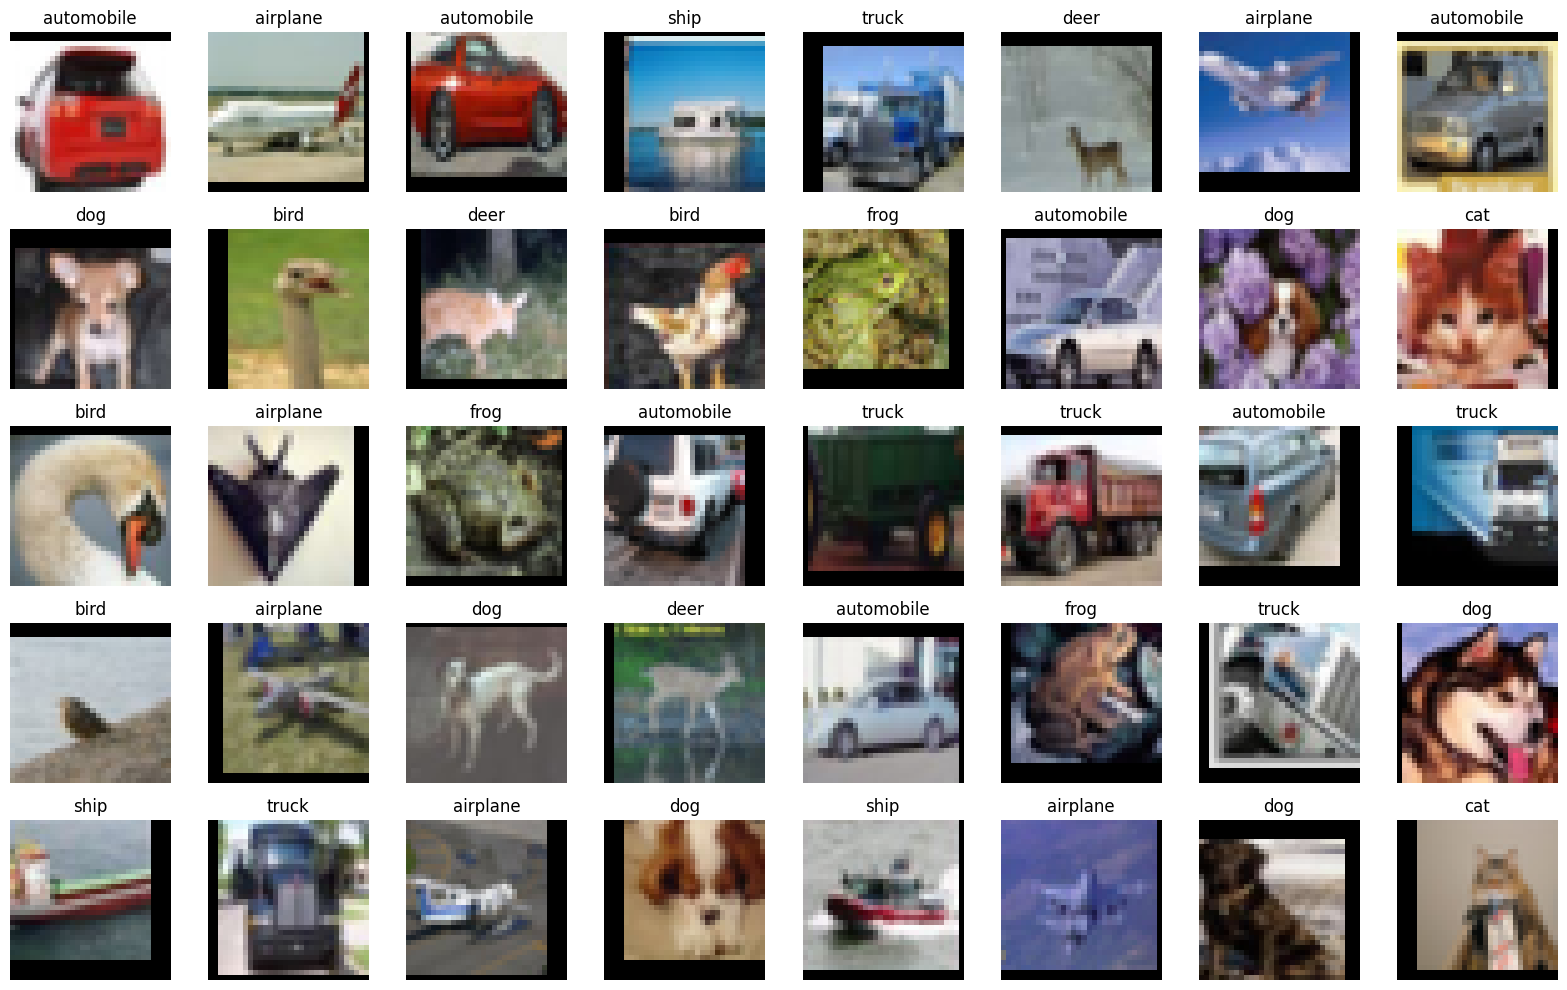

In [4]:
mappings = {
    0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 
    5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'
}

# Select a random set of indices from the training dataset.
indices = torch.randperm(len(train_dataset))[:40]

fig, axes = plt.subplots(5, 8, figsize=(16, 10))

for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]  

    image = image.permute(1, 2, 0).cpu().numpy()

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"{mappings[label]}")

plt.tight_layout()
plt.show()

### Задание 2: Квантование изображений (1.5 балла)

Теперь давайте разберёмся, как нам подготовить изображения для трансформера.  

Трансформеры работают с **дискретными токенами**, но стандартные цифровые изображения обычно хранят значения пикселей в виде дискретных целых чисел от 0 до 255. То есть каждый пискель может иметь одно из $256^3\approx 16.8$ миллиона возможных цветовых комбинаций. Если бы мы использовали каждую из этих комбинаций как отдельный токен для нашей модели, то у нас был бы просто огромный словарь, и вряд ли бы мы смогли обучить трансформер на таких данных.

Решение этой проблемы лежит в квантовании. Обычно в PyTorch мы используем преобразование `torchvision.transforms.ToTensor()`. Оно не только конвертирует изображение в тензор PyTorch, но и нормализует значения пикселей из диапазона $[0, 255]$ в диапазон $[0.0, 1.0]$. В итоге, наши данные становятся непрерывными.

Чтобы сделать их дискретными, в ImageGPT предложили метод квантования пикселей с помощью `K-Means`. Вместо того чтобы представлять каждый пиксель его `float` значением, мы группируем похожие цвета в небольшое, заранее заданное количество **цветовых кластеров** или **кодовых слов** (**codebook**). Каждый пиксель изображения затем заменяется целочисленным индексом того цветового кластера, к которому он наиболее близок.

Кратко процесс выглядит так:

1) **Собираем все пиксели из нашего датасета**.

2) **Применяем алгоритм K-Means к этим пикселям с желаемым количеством кластеров**.

В результате мы получаем $K$ кластеров. Каждый из них представляет собой усреднённый цвет (центроид) для своей группы пикселей. Эти центроиды и станут нашим словарём для дальнейшего квантования изображений.

Теперь давайте обучим `K-Means` на наших данных с `n_clusters=512` и сохраним кластеры в формате `.npy`.

In [5]:
def create_cifar10_centroids(n_clusters=512, save_path="./clusters/cifar10_clusters.npy"):
    
    print("Loading CIFAR-10...")
    dataset = CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transforms.ToTensor()  # при вычислении центроид не аугментируем
    ) # TODO: pay attention to transforms

    print("Extracting pixels...")
    all_pixels = []
    
    for img, _ in dataset:
        # Преобразуем тензор в numpy и поменяем размерность с (C, H, W) на (H*W, C)
        img_np = img.permute(1, 2, 0).numpy()  # сначала преобразуем размерность в (32, 32, 3)
        img_pixels = img_np.reshape(-1, 3)  # теперь получим все пиксели изображения (H*W, C) = (1024, 3)
        all_pixels.append(img_pixels)
        
    all_pixels = np.concatenate(all_pixels, axis=0)

    print(f"Clustering with KMeans (n_clusters={n_clusters})...")
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=42,
        n_init=10,
        max_iter=300,
        verbose=1
    )
    kmeans.fit(all_pixels)
    centroids = kmeans.cluster_centers_

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    np.save(save_path, centroids)
    print(f"Centroids saved to {save_path}")

In [11]:
create_cifar10_centroids(n_clusters=512, save_path="clusters/cifar10_clusters.npy")

Loading CIFAR-10...
Extracting pixels...
Clustering with KMeans (n_clusters=512)...
Initialization complete
Iteration 0, inertia 64437.4453125.
Iteration 1, inertia 60362.57421875.
Iteration 2, inertia 59276.31640625.
Iteration 3, inertia 58729.875.
Iteration 4, inertia 58391.98046875.
Iteration 5, inertia 58152.40234375.
Iteration 6, inertia 57973.375.
Iteration 7, inertia 57834.9296875.
Iteration 8, inertia 57721.4609375.
Iteration 9, inertia 57627.1484375.
Iteration 10, inertia 57544.0078125.
Iteration 11, inertia 57475.5078125.
Iteration 12, inertia 57412.125.
Iteration 13, inertia 57359.3828125.
Iteration 14, inertia 57316.3203125.
Iteration 15, inertia 57275.0390625.
Iteration 16, inertia 57239.72265625.
Iteration 17, inertia 57203.66796875.
Iteration 18, inertia 57176.62109375.
Iteration 19, inertia 57150.48828125.
Iteration 20, inertia 57129.83203125.
Iteration 21, inertia 57106.3828125.
Iteration 22, inertia 57086.19921875.
Iteration 23, inertia 57067.57421875.
Iteration 24, i

Также во время обучения нам понадобятся еще несколько вспомогательных функций:

- **`img_to_seq`**: преобразует двумерное изображение в одномерную последовательность токенов. Тут используем формат сначала размер последовательности, потом размер батча.

- **`quantize`**: принимает на вход изображение и преобразует его в изображение, где каждый пиксель заменен индексом ближайшего центроида из нашего словаря.

- **`unquantize`**: выполняет обратную операцию, которая принимает квантованное изображение и восстанавливает его в пиксельное представление
- **последовательность** батч с картинками приходит, сначала делаем quantize, потом вытягиваем с помощью img_to_seq

In [6]:
def img_to_seq(x):
    # Reshape x to [Batch_Size, H*W] and then transpose to [H*W, Batch_Size]
    # Use .contiguous() to avoid view() and inplace-ops errors after transpose.

    b, h, w = x.shape

    x = x.view(b, h * w).permute(1, 0).contiguous()  # [H*W, Batch_Size]

    return x

def quantize(x, centroids):
    b, c, h, w = x.shape

    # Преобразуем изображение в [Batch_Size * H * W, Channels]
    x_flat = x.permute(0, 2, 3, 1).reshape(-1, c)  # [b*h*w, c]

    # Преобразуем центроиды в тензор
    if isinstance(centroids, np.ndarray):
        centroids = torch.from_numpy(centroids).to(x.device)
    centroids = centroids.to(x.device)

    # Calculate Euclidean distance using (a-b)^2 = a^2 - 2ab + b^2 
    # and find the index of the closest centroid for each pixel
    # x^2
    x_norm = torch.sum(x_flat ** 2, dim=1, keepdim=True)  # [b*h*w, 1]
    # c^2
    c_norm = torch.sum(centroids ** 2, dim=1)  # [n_clusters]
    # xc
    dot_product = torch.matmul(x_flat, centroids.t())  # [b*h*w, n_clusters]

    # Расстояния: x^2 - 2xc + c^2 [b*h*w, n_clusters]
    # torch с помощью broadcasting расширяет x^2 с [b*h*w, 1] до [b*h*w, n_clusters]
    # а c^2 с [1, n_clusters] (unsqueeze(0) сделал [n_clusters] -> [1, n_clusters]) до [b*h*w, n_clusters]
    distances = x_norm - 2 * dot_product + c_norm.unsqueeze(0)

    # Находим индексы ближайших центроид (новые "цвета" пикселей)
    x = torch.argmin(distances, dim=1)  # [b*h*w]

    return x.view(b, h, w).contiguous()

def unquantize(x, centroids):

    b, h, w = x.shape
    n_clusters, c = centroids.shape

    # Преобразуем центроиды в тензор
    if isinstance(centroids, np.ndarray):
        centroids = torch.from_numpy(centroids).to(x.device)
    centroids = centroids.to(x.device)

    # Преобразуем индексы в плоский вид
    x_flat = x.reshape(-1).contiguous()  # [b*h*w]

    # Используем индексы для выбора соответствующих центроидов
    restored_flat = centroids[x_flat.long()]  # [b*h*w, c]

    # Преобразуем обратно в форму изображения для matplotlib: [batch_size, height, width, channels]
    restored = restored_flat.view(b, h, w, c)  # [b, h, w, c]

    return restored

### Задание 3: Embeddings (1.5 балла)

Чтобы трансформер мог работать с изображениями, их нужно преобразовать в понятный для него формат. В текстовых моделях слова сначала превращаются в  токены, а затем — в вектора эмбеддингов, в которых хранится "смысл слов".

С изображениями мы поступаем так же, но вместо слов мы работаем с пикселями. Мы уже отметили, что каждый пиксель в ImageGPT рассматривается как отдельный токен, который получает индекс из нашего словаря, созданного с помощью K-Means. Однако трансформеру нужны не просто эти индексы, а их векторные представления, которые он может обрабатывать. В процессе обучения эти векторы постепенно учатся отражать некоторые связи между пикселями, что позволяет модели понимать изображение.

В ImageGPT нам потребуются несколько типов эмбеддингов для кодирования входных изображений:

- **`token_embeddings`**: преобразуют индексы квантованных пикселей в вектора

- **`position_embeddings`**: кодируют информацию о позиции каждого пикселя, это позволяет модели улавливать пространственные отношения между ними

- **`class_embedding`**: преобразует индекс класса в вектор и выступает в роли условного стартового токена, который сообщает модели, изображение какого именно класса нужно генерировать

In [7]:
class GPTEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_positions, num_classes):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_embeddings = nn.Embedding(max_positions, embed_dim)
        self.class_embedding = nn.Embedding(num_classes, embed_dim)

    def forward(self, x, cls_label):
        
        tok_emb = self.token_embeddings(x)  # [seq_len, batch_size] -> [seq_len, batch_size, embed_dim]
        cls_token_emb = self.class_embedding(cls_label).unsqueeze(0)  # [batch_size] -> [1, batch_size, embed_dim]

        # Присоединим ембеддинг класса в начало последовательности: [seq_len + 1, batch_size, embed_dim]
        full_seq = torch.cat([cls_token_emb, tok_emb], dim=0) # concat cls_token

        # Позиционные эмбеддинги
        seq_len_with_start_emb = full_seq.size(0)  # seq_len + 1

        pos_ids = torch.arange(seq_len_with_start_emb, device=x.device)  # [seq_len + 1]
        pos_emb = self.position_embeddings(pos_ids)  # [seq_len + 1, embed_dim]

        # для broadcasting до [seq_len + 1, batch_size, embed_dim] на следующем шаге
        pos_emb = pos_emb.unsqueeze(1)  # [seq_len + 1, 1, embed_dim]

        # Return final embedding sequence:
        # Add positional information to full_seq
        embeddings = full_seq + pos_emb  # [seq_len + 1, batch_size, embed_dim]
        
        return embeddings

### Задание 4: Decoder Block (1.5 балла)

Теперь нам нужно собрать основные блоки нашей модели — блоки декодера. В каждом таком блоке последовательно будут выполняются следующие операции:

- **`LayerNorm`**
- **`MultiHeadAttention`**
- **`Residual Connection`**
- **`LayerNorm`**
- **`MLP`**:
  - **Linear**: $embed\; dim$ -> $4 \times embed\; dim$
  - **GELU Activation**
  - **Linear**: $(4 \times embed\; dim)$ -> $embed\; dim$
- **`Residual Connection`**

Поскольку наша модель является генеративной и предсказывает следующий элемент в последовательности, вам потребуется использовать **Masked Self-Attenion**.

Вы можете вопользоваться готовой реализацией **Multi-Head Attention** из Pytroch.

In [8]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=False,  # поскольку наш формат батчей: [seq_len, batch_size, embed_dim]
        )
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim)
        )

    def forward(self, x):
        # x [seq_len + 1, batch_size, embed_dim]

        # 1. LayerNorm + Masked Multi-Head Attention + Residual
        residual = x
        x = self.ln1(x)

        seq_len = x.size(0)
        # Создаем маску для предотвращения "заглядывания в будущее". По документации
        # True value indicates that the corresponding position is not allowed to attend.
        # Создадим квадратную матрицу [seq_len х seq_len] из True, у которой только все
        # элементы выше главной диагонали оставим True
        attn_mask = torch.triu(torch.ones(seq_len, seq_len) == 1, diagonal=1).to(x.device)

        # Masked Self-Attention
        attn_output, _ = self.attn(
            query=x,
            key=x,
            value=x,
            attn_mask=attn_mask,
            need_weights=False
        )  # [seq_len + 1, batch_size, embed_dim] - в доке: each head will have dimension embed_dim // num_heads
        x = residual + attn_output

        # 2. LayerNorm + MLP + Residual
        residual = x
        x = self.ln2(x)
        mlp_output = self.mlp(x)
        x = residual + mlp_output  # [seq_len + 1, batch_size, embed_dim]

        return x

### Задание 5: Final Model (1 балл)

Теперь, когда у нас есть все компоненты, мы можем собрать их вместе, чтобы построить итоговую модель ImageGPT.

Итоговая архитектура выглядит так:

- **`Embedding`**: преобразует входные токены в векторы

- **`Blocks`**: использует `num_layers` блоков `DecoderBlock`, которые последовательно обрабатывают наши данные

- **`Final LayerNorm`**: нормализует выходные данные перед финальным предсказанием

- **`Head`**: преобразует обработанные векторы в предсказания

- **`Centroids`**: храним центроиды как параметр модели, они необходимы для обратного преобразования токенов в реальные цвета.

In [9]:
class ImageGPT(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, max_positions, centroids_path, num_classes):
        super().__init__()
        self.embedding = GPTEmbedding(vocab_size, embed_dim, max_positions, num_classes)
        self.blocks = nn.ModuleList([
            DecoderBlock(embed_dim, num_heads) for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)

        # Загружаем центроиды и регистрируем как buffer
        centroids = torch.tensor(np.load(centroids_path), dtype=torch.float32)
        self.register_buffer('centroids', centroids)

    def forward(self, x, y):
        # x [seq_len, batch_size] y [batch_size]

        # Compute embeddings
        h = self.embedding(x, y)  # [seq_len + 1, batch_size, embed_dim]
        
        for block in self.blocks:
            h = block(h)  # [seq_len + 1, batch_size, embed_dim]
        
        # Apply final LayerNorm
        h = self.ln_f(h)  # [seq_len + 1, batch_size, embed_dim]
        
        # Project to vocabulary logits
        output = self.head(h)  # [seq_len + 1, batch_size, vocab_size]
        
        return output

In [10]:
centroids_path="clusters/cifar10_clusters.npy"

model = ImageGPT(
    centroids_path=centroids_path,
    embed_dim=512,
    num_heads=8,
    num_layers=24,
    max_positions=32*32,
    vocab_size=512,
    num_classes=10
    )

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 76,711,936


### Задание 6: Sampling (1.5 балла)

Для генерации новых изображений мы будем использовать уже обученную модель ImageGPT. Давайте напишем функцию **`sample`**, которая будет отвечать за это.

Она будет принимать на вход следующие параметры:

- **`model`**: наша обученная модель ImageGPT.

- **`length`**: число шагов генерации

- **`context`**: начальная последовательность пикселей, если мы хотим дорисовать изображение. Если её нет, генерация начнётся с нуля.

- **`class_label`**: метка класса для генерации по заданному условию

- **`temperature`**: параметр, который регулирует уровень случайности при генерации

- **`num_samples`**: количество изображений, которые нужно сгенерировать

In [11]:
def sample(model, length, class_label, num_samples=1, device='cuda',
           context=None, temperature=1.0):

    # expand it so that each generated image has a class label
    class_label = torch.tensor([class_label] * num_samples, dtype=torch.long, device=device)  # [num_samples]
    if context is None or context.size(0) == 0:
        context = torch.empty((0, num_samples), dtype=torch.long, device=device)
    else:
        if context.dim() == 1:
            # Add a new dimension to make it compatible with the model's input format.
            context = context.unsqueeze(-1)  # [context_len, 1]
        # Repeat the context to generate multiple images from the same starting sequence
        context = context.repeat(1, num_samples)  # [context_len, num_samples]
    # Начальная последовательность
    generated = context  # [context_len, num_samples]

    with torch.no_grad():
        # Implement the generation loop here
        for _ in range(length):
            # Рассчитаем логиты при сгенерированном входе generated
            logits = model(generated, class_label)  # [context_len, num_samples, vocab_size]

            # Логиты для следующего токена (последняя позиция выхода модели)
            next_token_logits = logits[-1:] / temperature  # [1, num_samples, vocab_size]

            # Вычислим softmax (получим вероятность того или иного токена в качестве следующего)
            probs = F.softmax(next_token_logits, dim=-1)  # [1, num_samples, vocab_size]

            # Выбираем из распределения следующий токен
            next_tokens = torch.multinomial(probs.view(-1, probs.size(-1)), 1)  # [num_samples, 1]
            next_tokens = next_tokens.transpose(0, 1)  # [1, num_samples]

            # Добавляем к последовательности
            generated = torch.cat([generated, next_tokens], dim=0)

    return generated  # [context_len + length, num_samples]

### Задание 7: Training and Validation Loop (1.5 балла)

После того как все компоненты модели собраны, мы можем приступить к обучению. Здесь вамм нужно реализовать основные функции для тренировки и валидации нашей модели.

In [12]:
def train_one_epoch(model, train_loader, optimizer, criterion, scheduler, device):
    
    model.train()  
    total_loss = 0.0

    for images, labels in tqdm(train_loader, desc="Train"):
        # Переносим данные на устройство
        images = images.to(device)  # [batch_size, 3, 32, 32]
        labels = labels.to(device)  # [batch_size]

        # Квантуем изображения в индексы центроидов нашими функциями
        with torch.no_grad():
            quantized = quantize(images, model.centroids)  # [batch_size, 32, 32]
            # Преобразуем в последовательность [seq_len, batch_size]
            tokens = img_to_seq(quantized)  # [1024, batch_size]
        # Учим предсказывать следующий токен, поэтому:
        # вход - все токены кроме последнего tokens[:-1] [1023, batch_size],
        # target - все токены кроме первого (сдвиг на 1 вправо) tokens[1:] [1023, batch_size].
        logits = model(tokens[:-1], labels)  # [1024, batch_size, vocab_size]

        # Вычисляем loss (игнорируем первый выход - prediction для class token)
        # [1023, batch_size, vocab_size] - только предсказания пикселей
        loss = criterion(logits[1:].reshape(-1, logits[1:].size(-1)), tokens[1:].reshape(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(# обнуляем (или set to None) посчитанные градиенты параметров
                set_to_none=True)  #set_to_none ускоряет, т.к. не присваивает всем элементам 0,
            # а делает None весь тензор, не поэлементно, но если на градиенты есть планы, то лучше обнулять
        if scheduler is not None:
            scheduler.step()
        total_loss += loss.item() * train_loader.batch_size
        torch.cuda.empty_cache()

    # Compute and return average loss for this epoch
    
    return total_loss / len(train_loader)


def validate_one_epoch(model, val_loader, criterion, device):

    model.eval()  
    total_loss = 0.0

    with torch.no_grad():  
        for images, labels in tqdm(val_loader, desc="Val"):
            # Переносим данные на устройство
            images = images.to(device)  # [batch_size, 3, 32, 32]
            labels = labels.to(device)  # [batch_size]
            # Квантуем изображения в индексы центроидов нашими функциями
            quantized = quantize(images, model.centroids)  # [batch_size, 32, 32]
            # Преобразуем в последовательность [seq_len, batch_size]
            tokens = img_to_seq(quantized)  # [1024, batch_size]
            # Учим предсказывать следующий токен, поэтому:
            # вход - все токены кроме последнего tokens[:-1] [1023, batch_size]
            # target - все токены кроме первого (сдвиг на 1 вправо). tokens[1:] [1023, batch_size]
            logits = model(tokens[:-1], labels)  # [1024, batch_size, vocab_size]

            loss = criterion(logits[1:].reshape(-1, logits[1:].size(-1)), tokens[1:].reshape(-1))
            total_loss += loss.item() * train_loader.batch_size

    # Compute and return average loss for this epoch
    
    return total_loss / len(val_loader)

def save_checkpoint(model, epoch, path_template):
    save_path = path_template.format(epoch=epoch+1)
    save_dir = os.path.dirname(save_path)
    if save_dir:  
        os.makedirs(save_dir, exist_ok=True)
        
    torch.save(model.state_dict(), save_path)
    print(f"Checkpoint saved: {save_path}")

def plot_losses(train_losses, val_losses):
    clear_output()
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

Для визуализации результатов работы нашей модели нам потребуется несколько вспомогательных функций. Ниже представлены некоторые функции, которые помогут нам подготовить данные, запустить процесс генерации и сравнить сгенерированные изображения с оригиналом.

In [17]:
def pick_val_sample(val_loader, device):
    img_sample, class_sample = next(iter(val_loader))
    img_sample = img_sample[0:1].to(device)
    class_sample = class_sample[0:1].to(device)
    return img_sample, class_sample

def generate_image_tokens(model, class_sample, h, w, device):
    num_tokens = h * w
    gen_seq = sample(
        model,
        context=None,
        class_label=class_sample,
        length=num_tokens,
        device=device
    ).cpu().numpy().squeeze()
    return gen_seq

def image_to_tokens(image_tensor, centroids):
    token_indices = quantize(image_tensor, centroids).cpu().numpy()
    return token_indices.reshape(-1)

def tokens_to_image(tokens, h, w, centroids):
    tokens_tensor = torch.tensor(tokens, dtype=torch.long).reshape(1, h, w)
    rgb_image = unquantize(tokens_tensor, centroids).cpu().numpy().squeeze()
    rgb_image = (rgb_image * 255).astype(np.uint8)

    return rgb_image

def plot_generated_vs_original(gen_img_rgb, original_img_rgb, class_label):
    final_img = np.concatenate([gen_img_rgb, original_img_rgb], axis=1)
    plt.figure(figsize=(4, 2))
    plt.title(f"Generated vs Original – Class {mappings[class_label]}")
    plt.imshow(final_img)
    plt.axis("off")
    plt.show()

def generate_and_plot_sample(model, val_loader, device):
    model.eval()
    centroids = model.centroids
    img_sample, class_sample = pick_val_sample(val_loader, device)
    h, w = img_sample.shape[-2:]

    gen_seq = generate_image_tokens(model, class_sample, h, w, device)
    generated_image_rgb = tokens_to_image(gen_seq, h, w, centroids)
    original_tokens = image_to_tokens(img_sample, centroids)
    original_image_rgb = tokens_to_image(original_tokens, h, w, centroids)
    
    plot_generated_vs_original(generated_image_rgb, original_image_rgb, class_sample.item())

In [14]:
def train_imagegpt(model, train_loader, val_loader, optimizer, criterion,
                   scheduler, checkpoint_path, device=device, epochs=10):

    model.to(device)

    train_loss_history, val_loss_history = [], []

    for epoch in range(epochs):

        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scheduler, device)
        train_loss_history.append(train_loss)
        val_loss = validate_one_epoch(model, val_loader, criterion, device)
        val_loss_history.append(val_loss)

        print(f"\nEpoch {epoch+1}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")

        plot_losses(train_loss_history, val_loss_history)
        save_checkpoint(model, epoch, f"{checkpoint_path}/imagegpt_epoch{epoch}.pt")
        generate_and_plot_sample(model, val_loader, device)

Теперь мы готовы запустить основной цикл обучения. Вы можете экспериментировать с различными гиперпараметрами и расписанием обучения, чтобы добиться хороших результатов.

In [15]:
# Обучение прерывалось после первой эпохи, кое-что исправлял в функциях
# вывода картинок. Потом качество не понравилось после 10 эпох. Загрузил чекпойнт и продолжил обучение.
checkpoint_path = "checkpoints_imagegpt/imagegpt_epoch9.pt"

# Загрузка state_dict
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

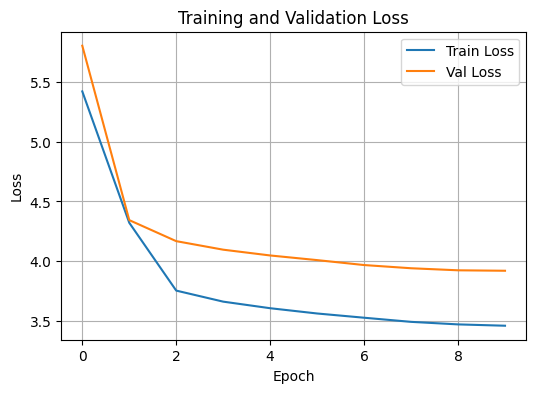

Checkpoint saved: checkpoints_imagegpt/imagegpt_epoch9.pt


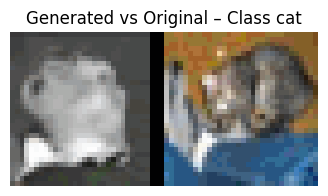

In [20]:
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader))
checkpoint_path = "checkpoints_imagegpt"

train_imagegpt(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    checkpoint_path=checkpoint_path,
    device=device,
    epochs=epochs
)

### Задание 8: Autocompletion (1 балл)

Ниже реализованы несколько функций для удобной отрисовки результатов. Используйте их, чтобы выполнить задание.

In [21]:
def pick_val_contexts(val_loader, num_contexts, device):
    context_images, class_labels = [], []
    with torch.no_grad():
        for images, batch_labels in val_loader:
            for img, label in zip(images, batch_labels):
                context_images.append(img.to(device))
                class_labels.append(label.to(device))
                if len(context_images) >= num_contexts:
                    return context_images, class_labels
    return context_images, class_labels

def prepare_context(img_tensor, context_size, centroids):
    original_tokens = image_to_tokens(img_tensor.unsqueeze(0), centroids).squeeze()
    context_tokens = original_tokens[:context_size]
    context_tensor = torch.tensor(context_tokens, dtype=torch.long, device=img_tensor.device)
    return context_tensor, original_tokens

def generate_variations(model, context_tensor, class_label, total_tokens, context_size, samples_per_context, temperature=1.0):
    generated_images = []
    h = w = int(total_tokens**0.5)
    centroids = model.centroids
    device = context_tensor.device

    for _ in tqdm(range(samples_per_context), desc="Generation", leave=False):
        gen_seq = sample(model, 
                         length=total_tokens - context_size, 
                         context=context_tensor,
                         class_label=class_label, 
                         temperature=temperature, 
                         device=device)
        gen_img_rgb = tokens_to_image(gen_seq.cpu().numpy().squeeze(), h, w, centroids)
        generated_images.append(gen_img_rgb)
    return generated_images

def plot_context_rows(rows_of_images, class_labels):
    num_contexts = len(rows_of_images)
    if num_contexts == 0:
        return
    num_cols = len(rows_of_images[0])
    fig, axs = plt.subplots(nrows=num_contexts, ncols=1, figsize=(num_cols * 2, num_contexts * 2.2))
    if num_contexts == 1: 
        axs = [axs]

    for i, (row, label) in enumerate(zip(rows_of_images, class_labels)):
        combined_row_img = np.concatenate(row, axis=1)
        axs[i].imshow(combined_row_img)
        axs[i].set_title(f"Class: {mappings[label]}")
        axs[i].axis("off")
    
    plt.tight_layout()
    plt.show()

In [22]:
def generate_and_plot_variations(model, val_loader, num_contexts=5, samples_per_context=5, context_size=512, temperature=1.0, device='cuda'):
    
    model.eval()
    centroids = model.centroids
    
    context_images, class_labels = pick_val_contexts(val_loader, num_contexts, device)
    h, w = context_images[0].shape[-2:]
    total_tokens = h * w
    all_rows_for_plotting = []
    plot_labels = [label.item() for label in class_labels]

    for img, label in tqdm(zip(context_images, class_labels), total=num_contexts):
        context_tensor, original_tokens = prepare_context(img, context_size, centroids)
        generated_imgs_rgb = generate_variations(
            model, context_tensor, label.unsqueeze(0), total_tokens, 
            context_size, samples_per_context, temperature=temperature
        )
        context_display_tokens = np.pad(original_tokens[:context_size], 
                                        (0, total_tokens - context_size), 
                                        'constant', constant_values=0)
        context_img_rgb = tokens_to_image(context_display_tokens, h, w, centroids)
        original_img_rgb = tokens_to_image(original_tokens, h, w, centroids)
        row = [context_img_rgb] + generated_imgs_rgb + [original_img_rgb]
        all_rows_for_plotting.append(row)

    plot_context_rows(all_rows_for_plotting, plot_labels)

После того как мы обучили модель, мы можем загрузить её, чтобы использовать для генерации. Код ниже загружает веса модели, которые были сохранены во время обучения.

In [23]:
checkpoint_path = "checkpoints_imagegpt/imagegpt_epoch9.pt"

model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"Model loaded from: {checkpoint_path}")

Model loaded from: checkpoints_imagegpt/imagegpt_epoch9.pt


Теперь давайте перейдем к исследованию способности модели к автодополнению. Ваша задача — проверить, насколько хорошо модель может дорисовывать изображения в зависимости от объёма контекста.

Запустить функцию `generate_and_plot_variations` три раза с разными значениями `context_size = {256, 512, 768}`.

Обратите внимание, как меняется качество сгенерированных изображений в зависимости от того, сколько контекста получила модель, и сделайте выводы.

100%|██████████| 5/5 [11:08<00:00, 133.60s/it]           


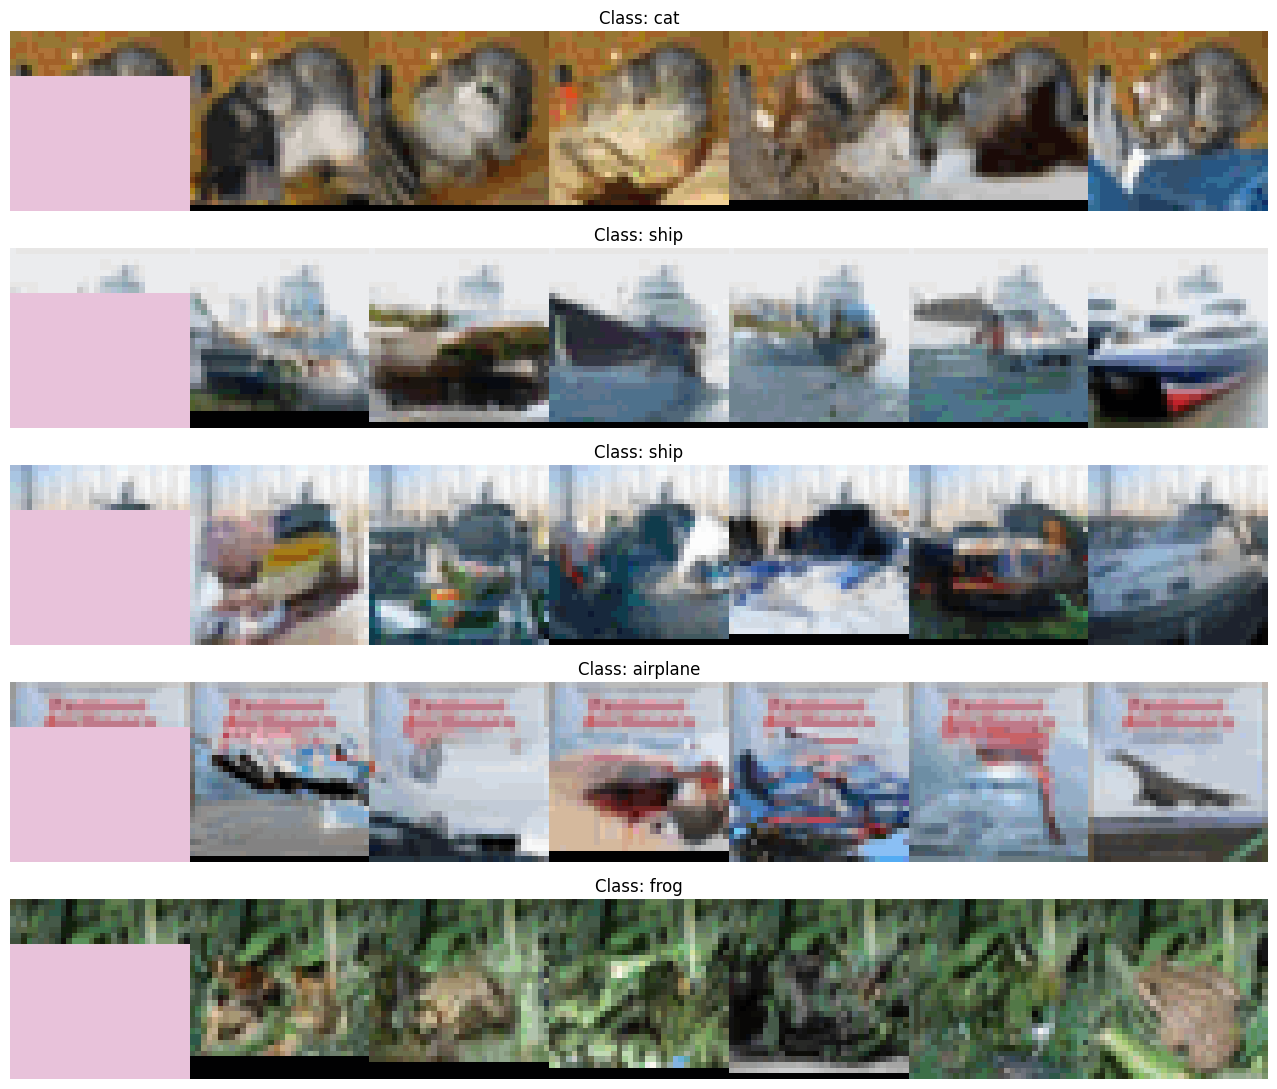

In [24]:
generate_and_plot_variations(model, val_loader, num_contexts=5, samples_per_context=5, context_size=256, temperature=1.0, device='cuda')

100%|██████████| 5/5 [08:16<00:00, 99.31s/it]            


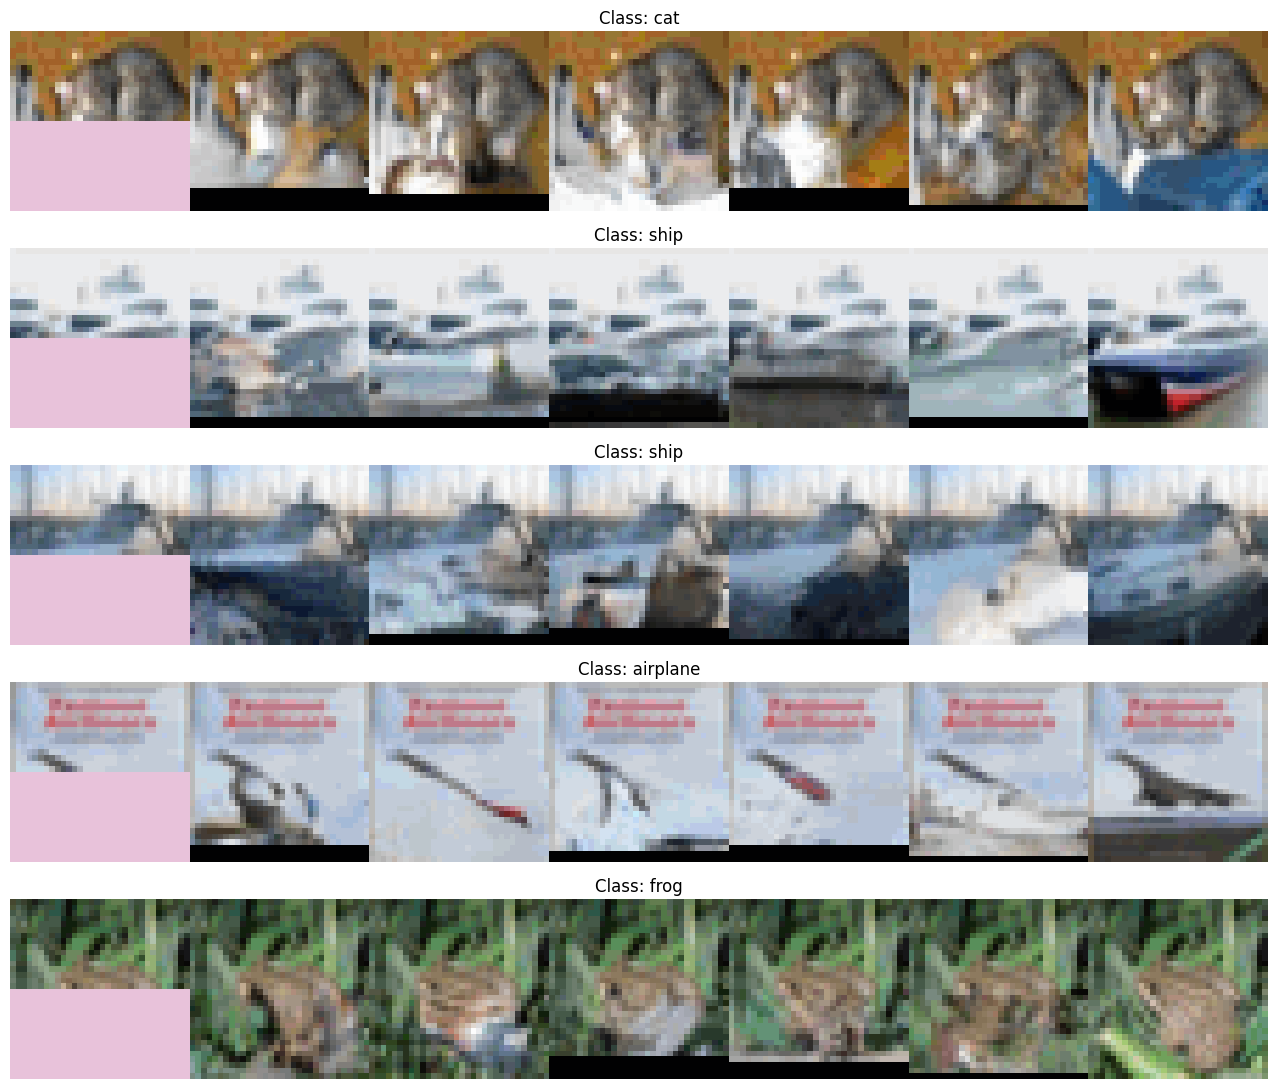

In [25]:
generate_and_plot_variations(model, val_loader, num_contexts=5, samples_per_context=5, context_size=512, temperature=1.0, device='cuda')

100%|██████████| 5/5 [04:43<00:00, 56.74s/it]            


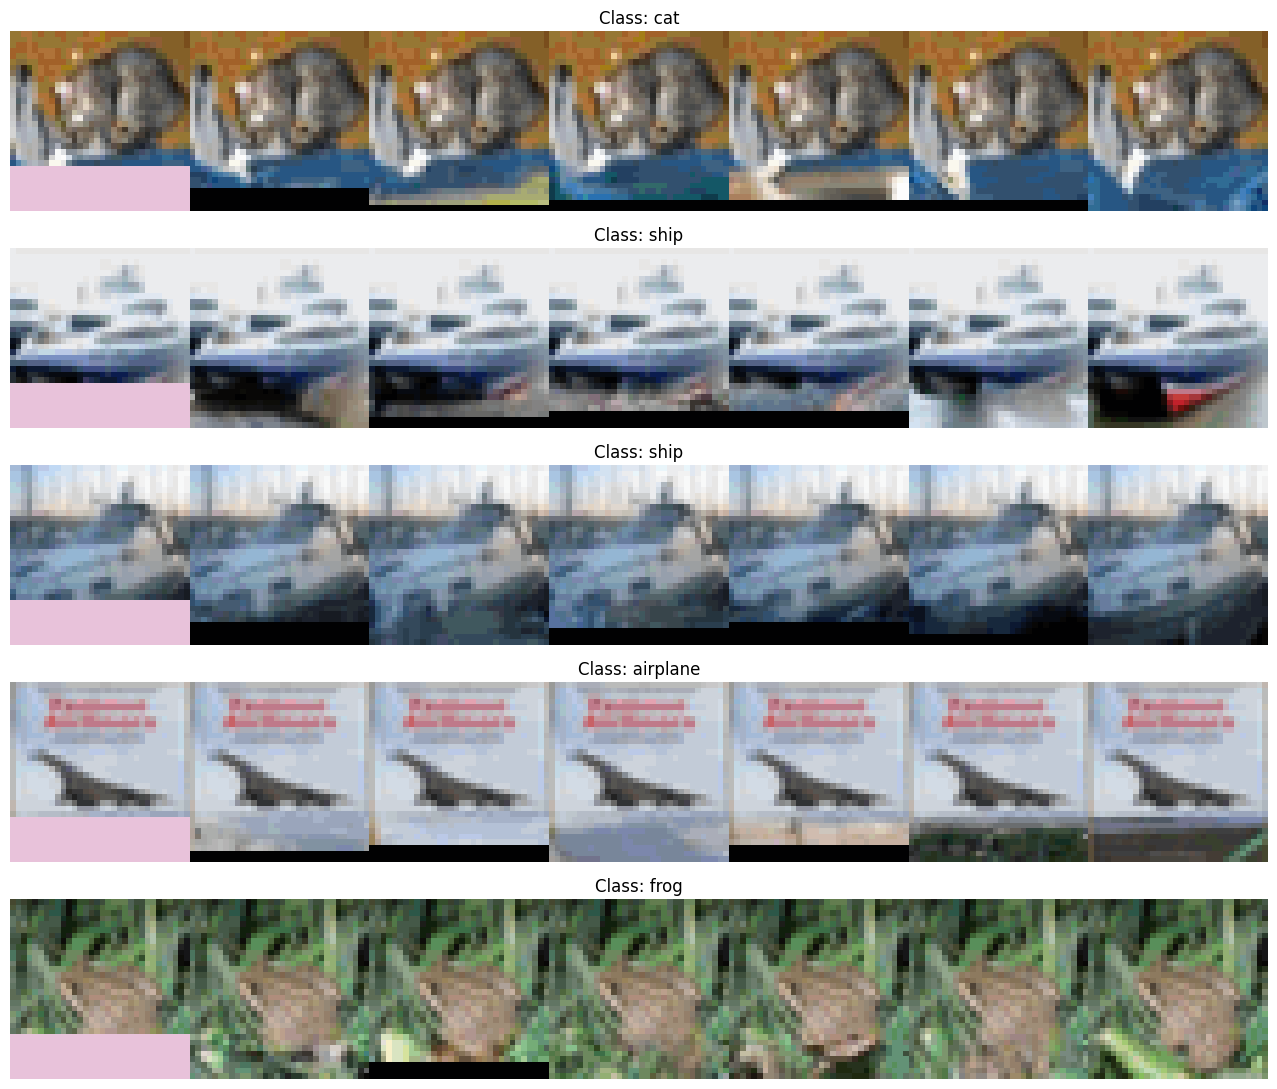

In [26]:
generate_and_plot_variations(model, val_loader, num_contexts=5, samples_per_context=5, context_size=768, temperature=1.0, device='cuda')

Выводы:
- за 20 эпох даже с таким маленьким размером батча модель смогла немного выучиться. Нельзя сказать, что хорошее качество генерации, но картинки похожи на картинки,
- при этом в целом видно, что чем больше контекста, тем модель получше дорисовывает картинку.

Теперь давайте исследуем влияние температуры на качество и разнообразие изображений. Этот параметр, как мы уже говорили, контролирует "случайность" предсказаний модели.

Запустите функцию `generate_and_plot_variations` три раза, используя одинаковый размер контекста `context_size=512`, но с разными значениями температуры `temperature = {0.9, 0.7, 0.5}`. Посмотрите на результаты и сделайте выводы.

100%|██████████| 5/5 [08:16<00:00, 99.30s/it]            


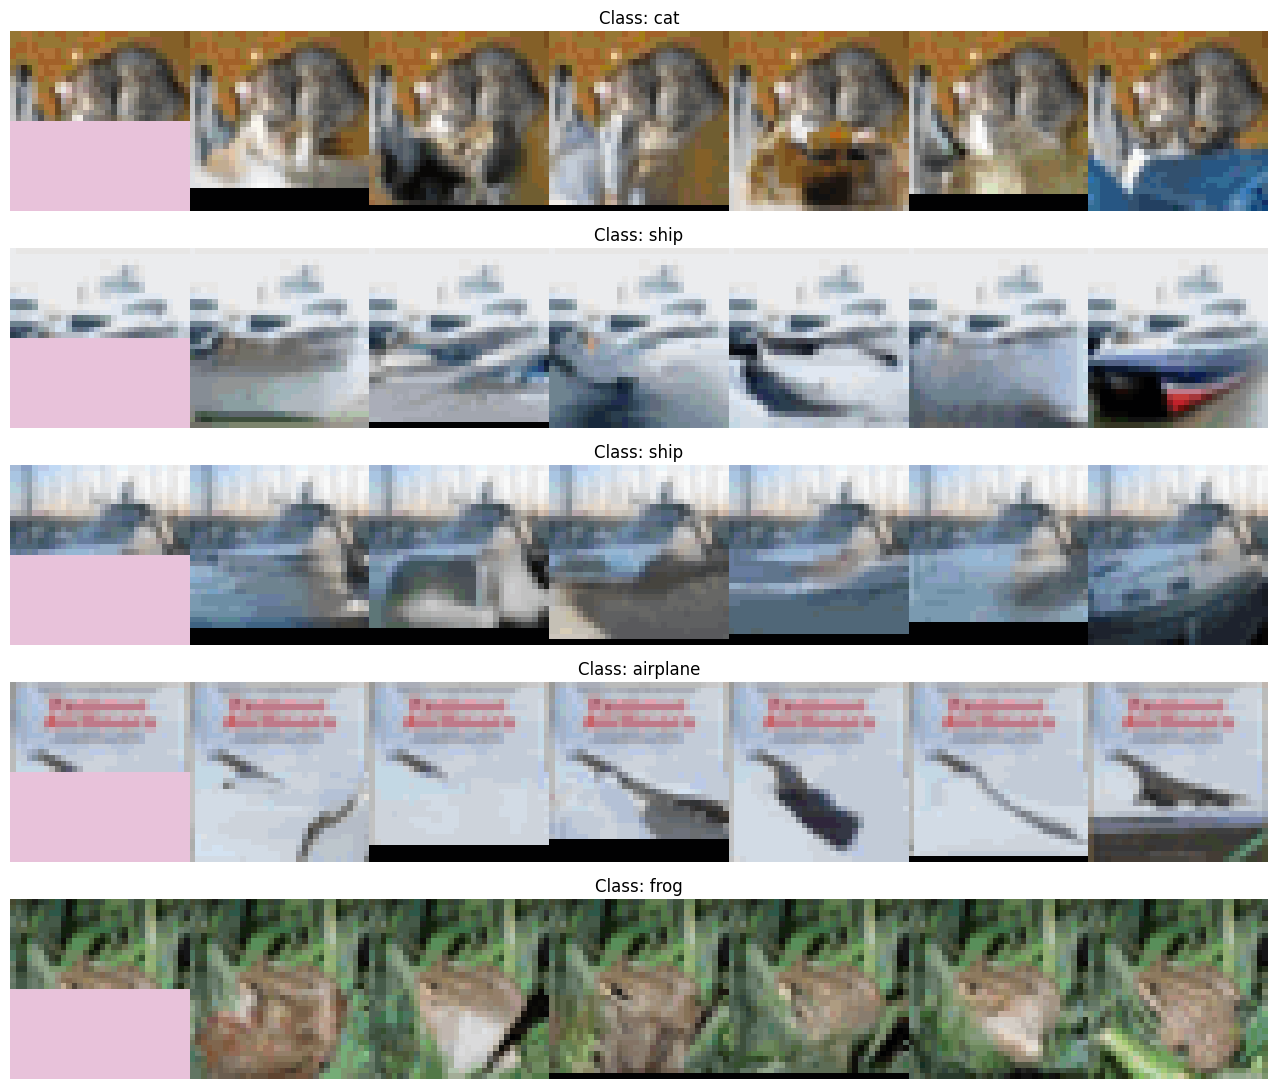

In [27]:
generate_and_plot_variations(model, val_loader, num_contexts=5, samples_per_context=5, context_size=512, temperature=0.9, device='cuda')

100%|██████████| 5/5 [08:17<00:00, 99.41s/it]            


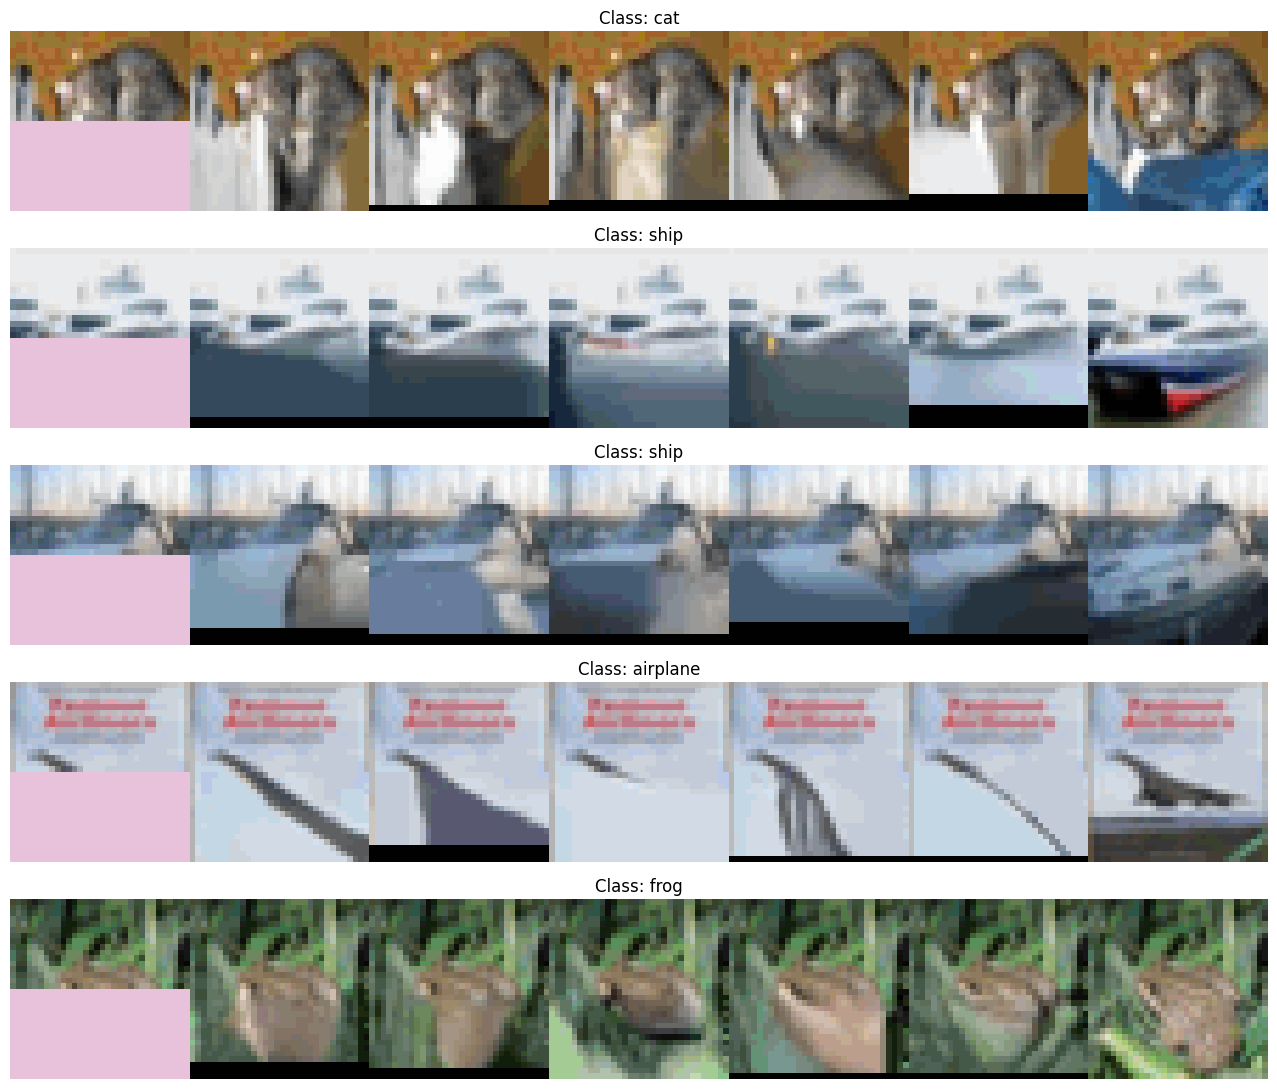

In [28]:
generate_and_plot_variations(model, val_loader, num_contexts=5, samples_per_context=5, context_size=512, temperature=0.7, device='cuda')

100%|██████████| 5/5 [08:14<00:00, 98.85s/it]            


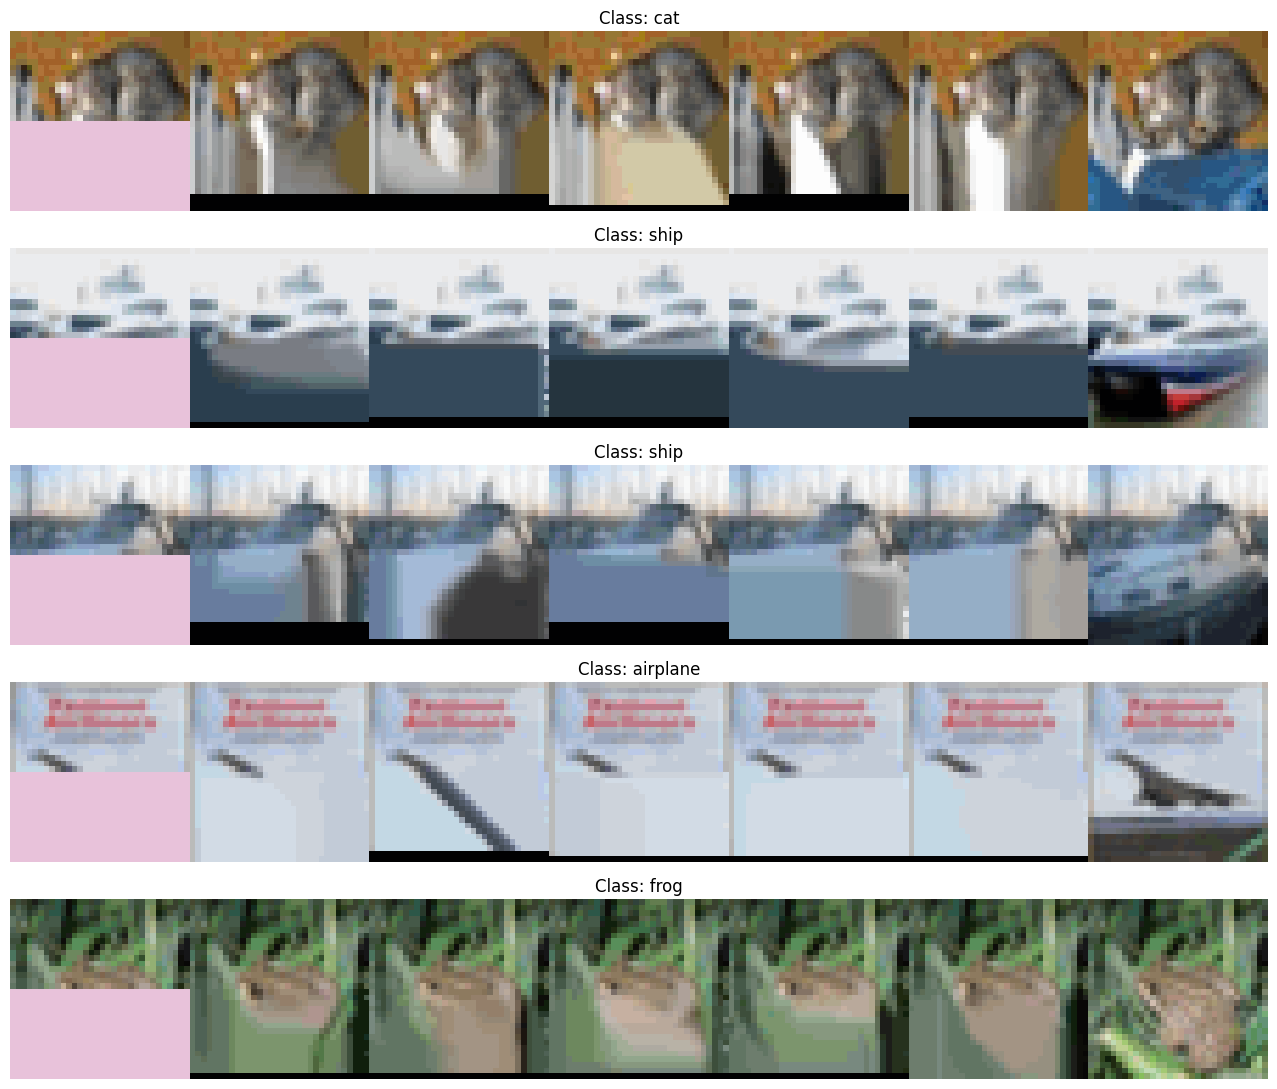

In [29]:
generate_and_plot_variations(model, val_loader, num_contexts=5, samples_per_context=5, context_size=512, temperature=0.5, device='cuda')

Выводы:
- за 20 эпох даже с таким маленьким размером батча модель смогла немного выучиться. Нельзя сказать, что хорошее качество генерации, но картинки похожи на картинки,
- при этом в целом видно, что чем ниже температура, тем меньше разных пикселей генерируется, модель стремится применять мало самых вероятных оттенков.

Здесь можно оставить отзывы, пожелания и впечатления о ДЗ :)
Дз понравилось, позволяет прочувствовать архитектуру трансформерного декодера. Лучше всяких картинок и статей - самому написать функции и архитектуру, почитать документацию.
Хотелось бы более очевидного описания функции sample, только к 9 заданию понимаешь, что от неё ожидается.